# Temperature sensitivity of CO2 emissions in layered cranberry soils
*Wilfried Dossou-Yovo, Serge Étienne Parent,Noura Ziadi, Bertrand Normand, and Léon Étienne parent*

In [27]:
print(Sys.Date())

[1] "2021-04-21"


## 1. Objective

This notebook generate the result of CO2 data analysis. Data set contains a collection of soil caracteristics, measured co2 emission collected from incubation study. Soil samples was collected from two cranberry fied stand of eastern canada. Incubation study was carried out at Agriculture and Agri-food Canada(sainte-foy, quebec,qc) from February to Mai 2019. The aim of this study was to measure CO2 emission rates in cranberry soils of Eastern Canada as related to soil temperature and depth

## 2. Statistical questions

In addition to data exploration, this notebook will answer the following statistical questions.
 
1. What is the influence of soil depth and temperature on CO2 emission?
2. Can Arrhenius equation and Q10 be useful to describe temperature sensitivity of carbon decomposition across layers? 

## 3. Packages

We need package [tidyverse](https://www.tidyverse.org/) which loads a set of packages for easy data manipulation(Ex: [dplyr](https://www.rdocumentation.org/packages/dplyr/versions/0.7.8)) and visualization (ex: [ggplot2](https://www.rdocumentation.org/packages/ggplot2/versions/3.2.1)). We also use [ggpubr](https://www.rdocumentation.org/packages/ggpubr/versions/0.1.1) to customise publication ready plot, [ggpmisc](https://www.rdocumentation.org/packages/ggpmisc/versions/0.2.17) and [grid](https://www.rdocumentation.org/packages/grid/versions/3.6.2) are useful packages as extensions to [ggplot2](https://www.rdocumentation.org/packages/ggplot2/versions/3.2.1).

In [28]:
library("tidyverse")
library(ggpubr)
library(ggpmisc)
library(grid)

### 4. Import data
We load two data `data_pot` and `data_co2` involved in our anylisis. `data_pot` contained details about sites sampling, soil sampling(soil depth, weight, water content and bulk density), laboratory incubation temperature while `data_co2` contained details about laboratory incubation time, co2 emission and jar masson details.
`data_co2` was combined with `data_pot` with `left_join` function

In [29]:
data_pots <- read_csv2('data/pots.csv')
data_co2 <- read_csv('data/co2.csv')
data_co2 <- data_co2 %>%
left_join(data_pots, by = "ID pot")

i Using ',' as decimal and '.' as grouping mark. Use `read_delim()` for more control.


-- Column specification --------------------------------------------------------
cols(
  `ID pot` = col_double(),
  Sites = col_character(),
  `Depth (cm)` = col_double(),
  Repetition = col_double(),
  `Temperature (°C)` = col_double(),
  `Pot weight (g)` = col_double(),
  `Soil weight (g)` = col_double(),
  `Water volume (ml)` = col_double(),
  `Water content (%)` = col_double(),
  `Bulk density (g/cm3)` = col_double(),
  `Carbone(%)` = col_double(),
  pHCaCl2 = col_double()
)



-- Column specification --------------------------------------------------------
cols(
  `ID pot` = col_double(),
  `Time (days)` = col_double(),
  `Initial CO2 (ppm)` = col_double(),
  `Final CO2 (ppm)` = col_double(),
  `Time final (h)` = col_double()
)




## 5. Some calculations 

Several variables have been added to our data in order to proceed for analysis. The added variables are the following: `Temperature (Kelvin)`, `Molar Volume (L/mol)`, `Headspace Volume (mL)`, `Dry soil weight (g)`, `CO2 emission (ug/h/g)`, `CO2 emission (mg/kg)`, `decomposition rate K`, `lnK`and `1/T(T = Temperature(Kelvin)`

In [30]:
container_volume <- 250 # mL
gas_constant <- 8.31446 # unit
atm_pressure_n <- 101.325

data_co2 <- data_co2 %>%
  mutate(`Temperature (K)` = `Temperature (°C)` + 273,
         `Total carbon (Mg/ha)` = `Bulk density (g/cm3)` * `Carbone(%)` * 10,
         `Molar Volume (L/mol)` = gas_constant * `Temperature (K)` / atm_pressure_n,
         `Headspace Volume (mL)` = container_volume - (`Soil weight (g)` / `Bulk density (g/cm3)`), # 250 mL is the volume of the container
         `Dry soil weight (g)` = `Soil weight (g)` - (`Soil weight (g)` * `Water content (%)` / 100),
         `CO2 emission (ug/h/g)` = (`Final CO2 (ppm)` - `Initial CO2 (ppm)`) * 0.000001 * 44000000 /
                                   `Molar Volume (L/mol)` * (`Headspace Volume (mL)` / 1000) * (12 / 44) /
                                   `Time final (h)` / `Dry soil weight (g)`,
         `CO2 emission (mg/kg)` = `CO2 emission (ug/h/g)` * 24 * `Time (days)`,
         `CO2 emission (Mg/ha)` = `CO2 emission (mg/kg)` * `Bulk density (g/cm3)` * 10 * 0.0001,
         K = log(`Total carbon (Mg/ha)` / (`Total carbon (Mg/ha)` - `CO2 emission (Mg/ha)`)) / `Time (days)`,
         lnK = log(K),
         `1/T` = 1 / `Temperature (K)`)

Warning message in log(K):
"production de NaN"


## 6. Data Exploration

### 6.1 Boxplot

In [31]:
New.labs <- c("10°C", "20°C", "30°C") # Change labels 
names(New.labs) <- c("10", "20", "30")

New.labs_b <-  c("[0-10 cm]", "[10-20 cm]", "[20-30 cm]") # Change labels
names(New.labs_b) <- c("10", "20", "30")

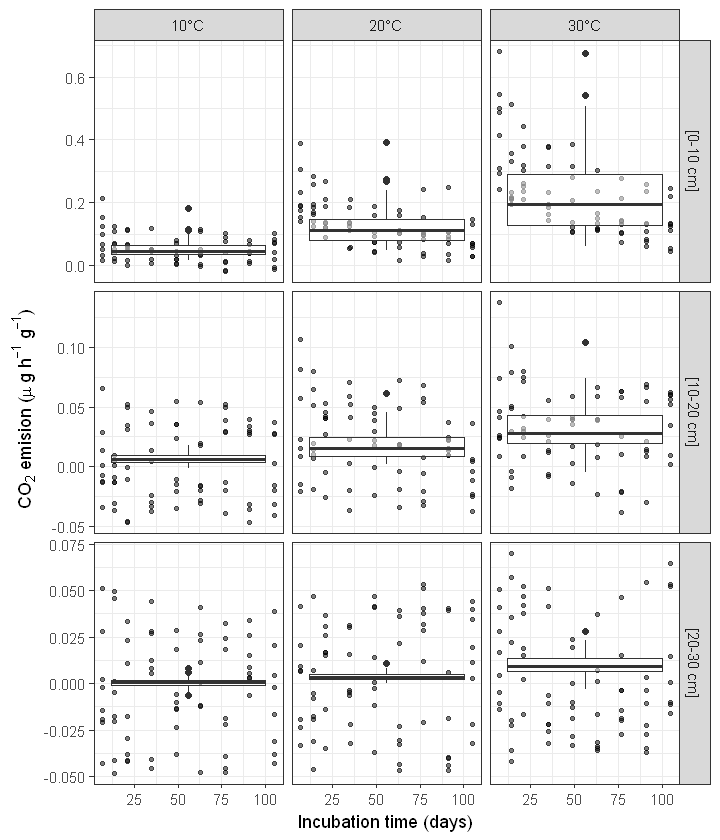

In [32]:
options(repr.plot.width = 6, repr.plot.height = 7)
pg <- ggplot(data=data_co2, aes(x = `Time (days)`,y = `CO2 emission (ug/h/g)` , group = `Temperature (°C)`)) +
geom_boxplot() + 
facet_grid(`Depth (cm)` ~ `Temperature (°C)`,   scales = "free", 
          labeller = labeller(`Depth (cm)` = New.labs_b, `Temperature (°C)` = New.labs))+ 
geom_jitter(width = 1/40, # very small width for the random noise
                                  height = 1/20, # very small height for the random noise
                                  alpha = 1/2, # transparent so we can see clustering
                                  size = 1) + # very small points 
  theme(legend.position = "none") +
        geom_boxplot(alpha=0.5)+
 xlab("Incubation time (days)") + ylab(bquote(~CO[2]~ 'emision ('*mu~'g'~ h^-1~g^-1*')'))
pg 
ggsave("figures/Boxplot.png", width = 6, height = 7, dpi = 600)# export plot high resolution

## 7.What is the influence of soil depth and temperature on CO2 emission?

### 7.1 linear regression

In [33]:
data_co2 <- data_co2 %>%
  rename(Co2 = `CO2 emission (ug/h/g)`,
         Time = `Time (days)`,
         Layers = `Depth (cm)`,
         Temperature = `Temperature (°C)`,
         Total_carbon = `Total carbon (Mg/ha)`,
         Id = `ID pot`)%>%
  drop_na() %>%
  droplevels()

co2_lm <- lm((log10(Co2)) ~ Time + Layers + Temperature,
                     data = data_co2) 

In [34]:
summary(co2_lm)


Call:
lm(formula = (log10(Co2)) ~ Time + Layers + Temperature, data = data_co2)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.3504 -0.1473  0.0314  0.1692  0.7925 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.8351070  0.0407928  -20.47   <2e-16 ***
Time        -0.0034012  0.0003185  -10.68   <2e-16 ***
Layers      -0.0749675  0.0013240  -56.62   <2e-16 ***
Temperature  0.0360113  0.0013288   27.10   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.2625 on 607 degrees of freedom
Multiple R-squared:  0.8622,	Adjusted R-squared:  0.8615 
F-statistic:  1266 on 3 and 607 DF,  p-value: < 2.2e-16


### Residual sum of squares:

In [35]:
RSS <- c(crossprod(co2_lm$residuals))
RSS

[1] 41.8321

### Mean squared error

In [36]:
MSE <- RSS / length(co2_lm$residuals)
MSE

[1] 0.06846498

### Root MSE

In [37]:
RMSE <- sqrt(MSE)
RMSE

[1] 0.2616581

### P-value

In [38]:
summary(co2_lm)$coefficients[,4]

(Intercept)          Time        Layers   Temperature 
 3.200866e-71  1.635358e-24 2.154601e-244 1.333228e-106

### 7.2 Reporting the results of the linear regression

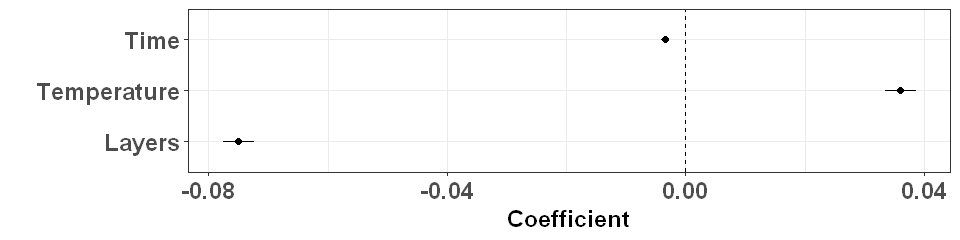

In [39]:
options(repr.plot.width = 8, repr.plot.height = 2)
ic <- confint(co2_lm, level = 0.95)
co <- coef(co2_lm)
co2_lm_res <- tibble(variable = rownames(ic),
                         ll = ic[, 1], est = co, ul = ic[, 2])

co2_lm_res %>%
  filter(variable != "(Intercept)") %>%
  ggplot(aes(x = est, y = variable)) +
  geom_vline(xintercept = 0, lty = 2) +
  geom_segment(mapping = aes(
    x = ll,
    xend = ul,
    yend = variable
    )
  ) +
xlab('Coefficient') +
  ylab('') +
  geom_point() +
theme(strip.text.y = element_text(angle=0),
        legend.title = element_blank(),
        legend.position = "bottom",
        text = element_text(size = 18, face="bold"),
      axis.title=element_text(size=14,face="bold")) +
ggsave("figures/Linear-model-Co2.png", width = 8, height = 2, dpi = 600)

### 7.3 Prediction model of CO2 emission in cranberry soils in three-layer positions (0-10 cm, 10-20 cm, 20-30 cm) and at three temperatures (10, 20 and 30oC).
Here, we use our model `co2_lm` to predict co2 emission trend. In order to do that, we create a new data called `Data_exp` following predicted Co2 column. The trend line was drawn with `data_exp`

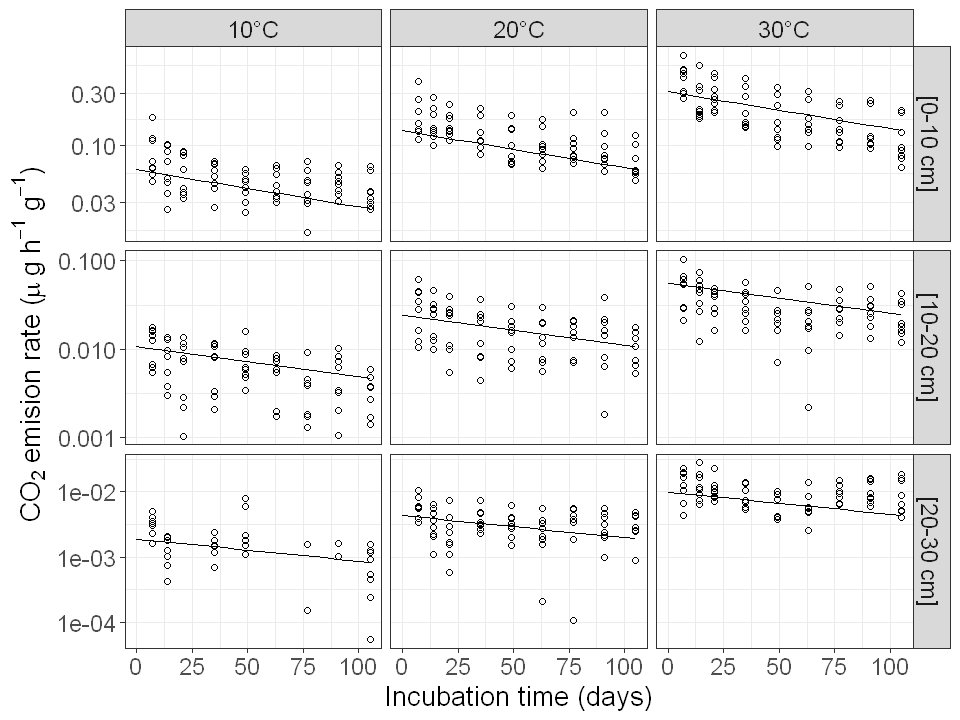

In [40]:
New.labs <- c("10°C", "20°C", "30°C") # Change labels 
names(New.labs) <- c("10", "20", "30")

New.labs_b <-  c("[0-10 cm]", "[10-20 cm]", "[20-30 cm]") # Change labels
names(New.labs_b) <- c("10", "20", "30")

Data_exp <- expand.grid(Time = seq(0, 105, 5), Layers = c(10, 20, 30), Temperature = c(10, 20, 30))
Data_exp$Co2 <- 10^predict(co2_lm, newdata = Data_exp, level=0)

options(repr.plot.width = 8, repr.plot.height = 6)
theme_set(theme_bw())
pl <- ggplot(data = data_co2, aes(x = Time, y = Co2)) +
 facet_grid(Layers ~ Temperature, scales = "free", labeller = labeller(`Layers` = New.labs_b, `Temperature` = New.labs)) +
  xlab("Incubation time (days)") + ylab(bquote(~CO[2]~ 'emision rate ('*mu~'g'~ h^-1~g^-1*')'))
pl + geom_point(shape=1, size = 1.5) +
  geom_line(data = Data_exp) +
scale_y_log10() +
theme_bw() +
theme(strip.text = element_text(size = 14), axis.text=element_text(size=14),
        axis.title=element_text(size=16),
     axis.title.y = element_text(size=16)) +
  
ggsave("figures/CO2 emission.png", width = 8, height = 6, dpi = 600)# export plot high resolution

### 7.4 Normality test

In [41]:
shapiro.test(data_co2$Co2)


	Shapiro-Wilk normality test

data:  data_co2$Co2
W = 0.64207, p-value < 2.2e-16


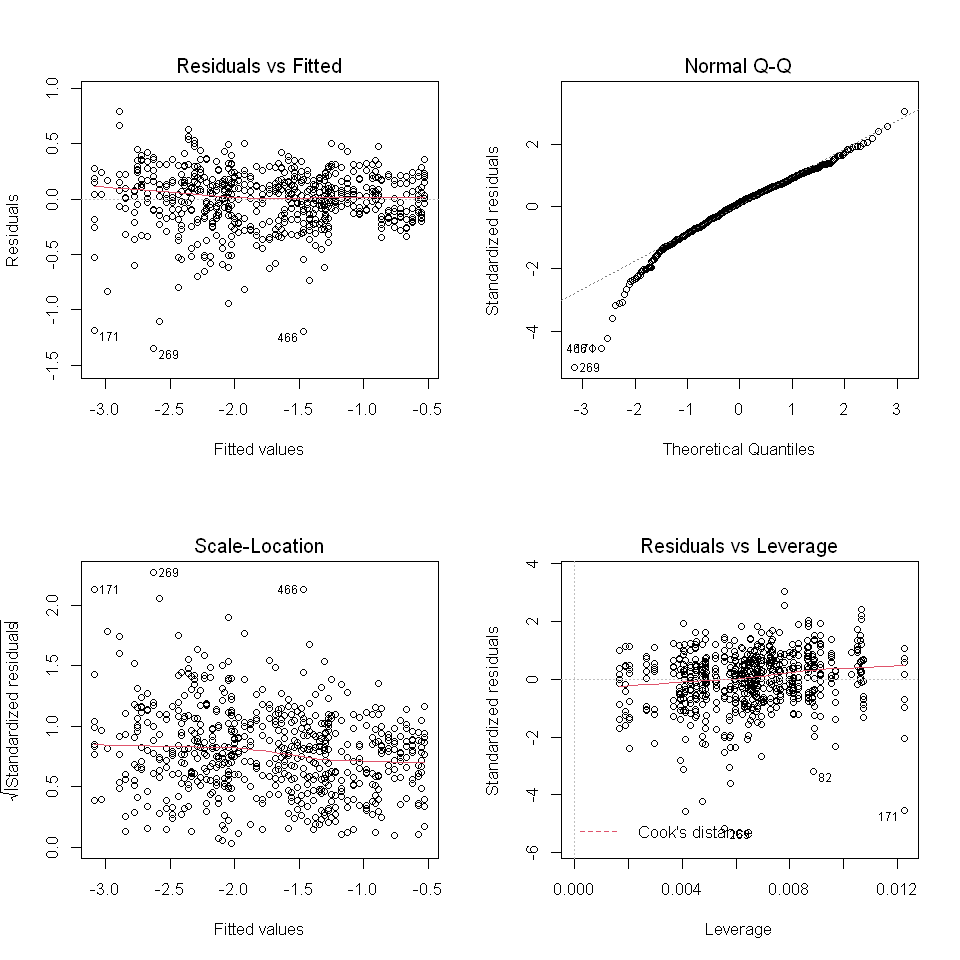

In [42]:
options(repr.plot.width=8, repr.plot.height=8)
par(mfrow = c(2, 2))
plot(co2_lm)

## 8. What is the temperature sensitivity across cranberry soil layers?

### 8.1 Fit of Arrhenius equation

The Arrhenius equation has been used to describe temperature sensitivity to CO2 emission. The Arrhenius equation was computed as follows: 



$$k = A e^{{\frac{-Ea}{RT}}}$$

$$log \left( k \right) = log \left( A e^{\frac{-Ea}{RT}} \right)$$

$$log \left( k \right) = log \left( A \right) + log \left(e^{\frac{-Ea}{RT}} \right)$$

$$log \left( k \right) = log \left( A \right) - \frac{1}{T} \times \left(\frac{Ea}{R}\right)$$

Where $A$ is the pre-exponential factor and $Ea$ is activation energy assumed to be independent of temperature, $R$ is the universal gas constant and $T$ is absolute temperature (Kelvin)

In [43]:
models_co2 <- data_co2 %>%
  group_by(`Layers`) %>%
  summarise(linmod = list(lm(lnK ~ `1/T`)))

linmod_coef <- list()
for (i in seq_along(models_co2$linmod)) linmod_coef[[i]] <- models_co2$linmod[[i]]$coefficients
linmod_coef <- do.call(rbind.data.frame, linmod_coef)
names(linmod_coef) <- c("Intercept", "Slope")
linmod_coef <- bind_cols(unique(data_co2["Layers"]), linmod_coef)

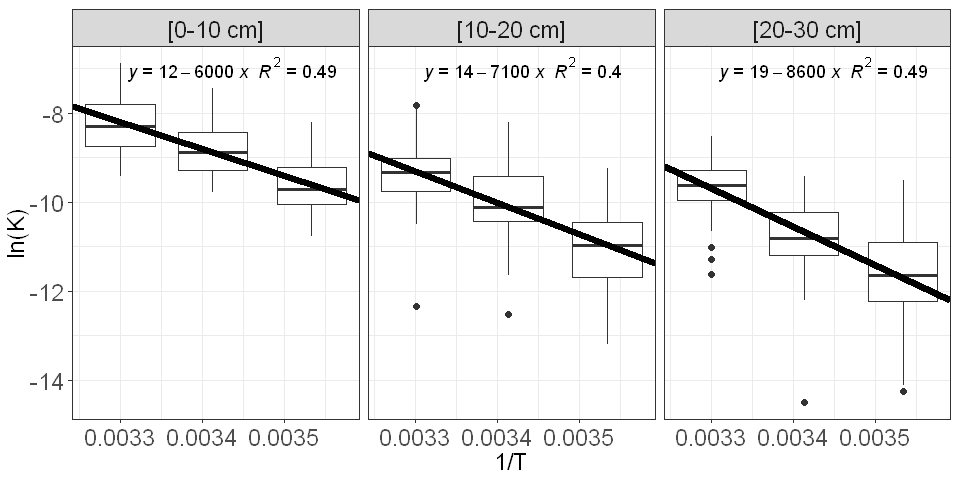

In [44]:
options(repr.plot.width = 8, repr.plot.height = 4)
  data_co2 %>%
  ggplot(aes(x = `1/T`, y = lnK)) +
  facet_grid(~`Layers`, labeller = labeller(`Layers` = New.labs_b)) +
  geom_boxplot(aes(group = factor(`1/T`))) +
stat_regline_equation(aes(label =  paste(..eq.label.., ..rr.label.., sep = "~~")), label.x = 0.00331, label.y = -7) +
  geom_abline(data = linmod_coef, aes(intercept = Intercept, slope = Slope), lwd = 2) +
  labs(y = "ln(K)") +
theme_bw() +
theme(strip.text = element_text(size = 14), axis.text=element_text(size=14),
        axis.title=element_text(size=14)) +
ggsave("figures/Arrhénius équation.png", width = 8, height = 4, dpi = 600)# export plot high resolution

### 8.2 Activation Energy computation

In [45]:
Activation_energy <- tibble(
    Soil_layers = c("10", "20", "30"),
    intercept = NA,
    slope = NA,
    adj_r_sq = NA
)

In [46]:
lm_arrhenius <- for (i in 1:nrow(Activation_energy)) {
    
    lm_Activation_energy <- data_co2 %>%
      filter(`Layers` == Activation_energy$Soil_layers[i]) %>%
      lm(lnK ~ `1/T`, data = .)
    
    # intercept
    Activation_energy$intercept[i] <- coef(lm_Activation_energy)[1]

    # Slope
     Activation_energy$slope[i] <- coef(lm_Activation_energy)[2]
   
    # statistics
    Activation_energy$adj_r_sq[i] <- summary(lm_Activation_energy)$adj.r.squared
}

In [47]:
R = 8.3144621 / 1000 # Gas constant Kj/mol/K 
Activation_energy <-  Activation_energy %>%
  mutate(Ea = -slope * R) %>%
  select(Soil_layers, adj_r_sq, Ea)
Activation_energy

Soil_layers,adj_r_sq,Ea
<chr>,<dbl>,<dbl>
10,0.4880430,49.90107
20,0.4015598,58.63364
30,0.4897419,71.15313


### 8.3 Computing K median in order to compute Q10 value accross soil depth

In [48]:
K_median <- aggregate(K ~ `Layers` + `Temperature`, data = data_co2, FUN = median)
K_median_01 <- K_median %>%
  pivot_wider(names_from = `Temperature`, values_from = K)

K_median_01$Q_20_10 <- K_median_01$`20` / K_median_01$`10`
K_median_01$Q_30_20 <- K_median_01$`30` / K_median_01$`20`
K_median_01

Layers,10,20,30,Q_20_10,Q_30_20
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
10,5.997791e-05,1.390499e-04,2.502378e-04,2.318351,1.799627
20,1.704718e-05,4.075907e-05,8.805731e-05,2.390957,2.160435
30,8.780531e-06,1.993569e-05,6.657057e-05,2.270443,3.339266


In [49]:
K_median_02 <- aggregate(K ~ `Sites` + `Time` + `Layers` + `Temperature`, data = data_co2, FUN = median)

K_median_02 <- K_median_02 %>%
  pivot_wider(names_from = `Temperature`, values_from = K)

#K_median_02
K_median_02$Q_20_10 <- K_median_02$`20` / K_median_02$`10`
K_median_02$Q_30_20 <- K_median_02$`30` / K_median_02$`20`
K_median_02 <- K_median_02 %>%
na.omit(K_median_02)
data_Q10 <- gather(data = K_median_02, key = `Temperature range`, value = Q10, c(`Q_20_10`, `Q_30_20`),
                    factor_key=TRUE)


In [50]:
data_Q10$Log_Q10 <- log10(data_Q10$Q10)

Q10_lm <- lm(log(Q10) ~  Layers,
                     data = data_Q10) 

In [51]:
summary(Q10_lm)


Call:
lm(formula = log(Q10) ~ Layers, data = data_Q10)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.42266 -0.19647 -0.05162  0.20068  0.97976 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.530342   0.092118   5.757 1.02e-07 ***
Layers      0.014186   0.004482   3.165  0.00208 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.35 on 96 degrees of freedom
Multiple R-squared:  0.09449,	Adjusted R-squared:  0.08506 
F-statistic: 10.02 on 1 and 96 DF,  p-value: 0.002077


`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



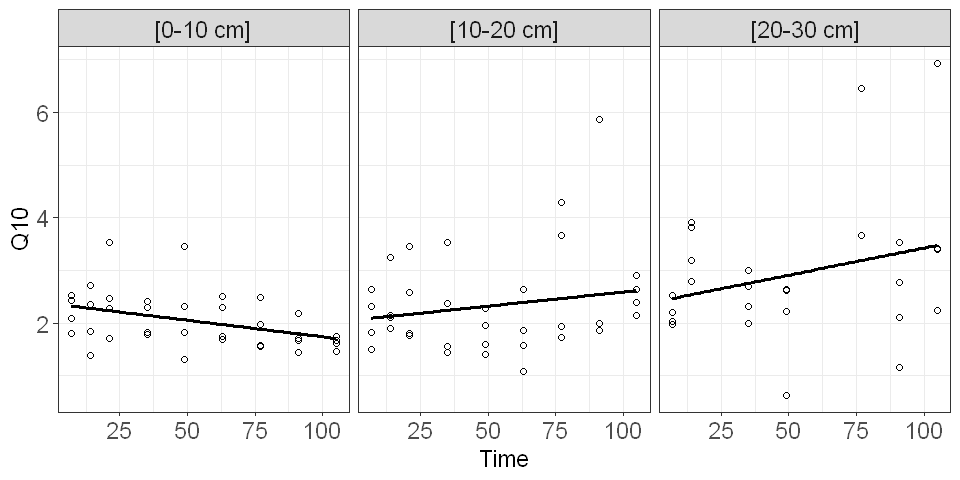

In [52]:
options(repr.plot.width = 8, repr.plot.height = 4)
data_Q10$`Layers` <- as.character(data_Q10$`Layers`)
ggplot(data=data_Q10, aes(x = `Time`, y = `Q10`)) +
facet_grid(.~`Layers`, labeller = labeller(`Layers` = New.labs_b)) +
geom_smooth(method = "lm", se = FALSE, color = "Black") +
geom_point(shape=1, size = 1.5) +
theme_bw() + 
theme(strip.text = element_text(size = 14), axis.text=element_text(size=14),
        axis.title=element_text(size=14)) 
ggsave("figures/Variation of Q10 across layers.png", width = 8, height = 4, dpi = 600)# export plot high resolution

## 9. Soil description

### 9.1 Soil layers properties

Import data

In [53]:
data_carbon_credit <- read_csv2('data/data_carbon_credit.csv')
data_carbon_credit <- data_carbon_credit %>%
mutate(`C:N ratio` = `Carbone (%)` / `Nitrogen (%)`)

i Using ',' as decimal and '.' as grouping mark. Use `read_delim()` for more control.


-- Column specification --------------------------------------------------------
cols(
  Sample = col_double(),
  Location = col_character(),
  `Layer (cm)` = col_character(),
  `0_30_ID` = col_character(),
  `Site age` = col_double(),
  Repetition = col_double(),
  `Bulk density (kg m-3)` = col_double(),
  pHCaCl2 = col_double(),
  `Sand carbon (%)` = col_double(),
  `Carbone (%)` = col_double(),
  `Sulfur (%)` = col_double(),
  `Nitrogen (%)` = col_double(),
  `C stock (kg m-3)` = col_double(),
  `Total porosity` = col_double(),
  `Water content (%)` = col_double()
)




Some calculations

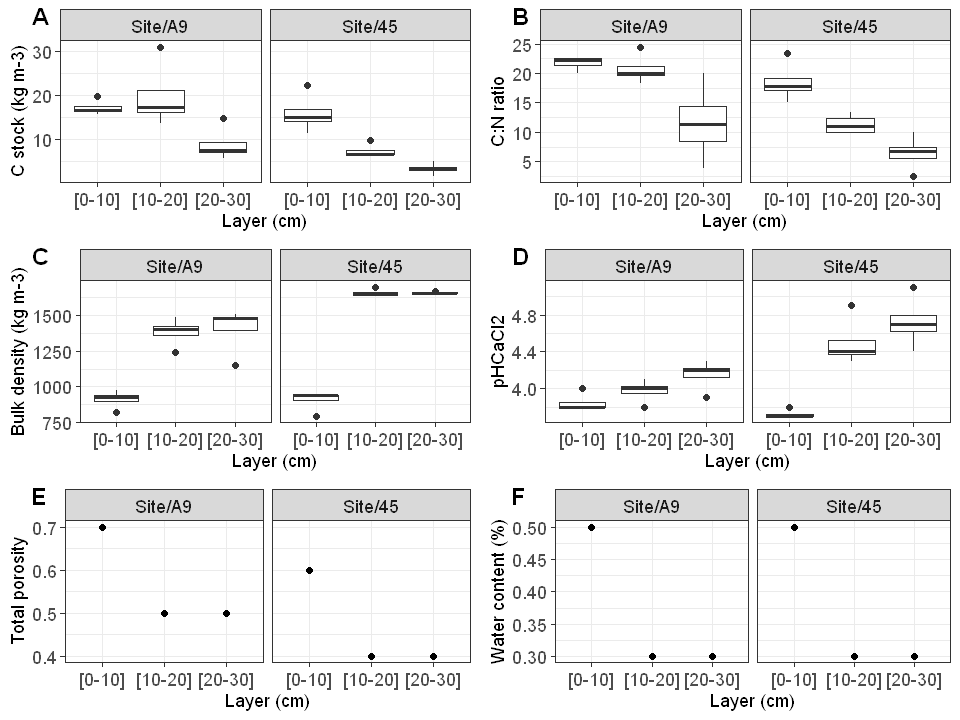

In [54]:
New.labs_c <-  c("Site/A9", "Site/45") # Change labels
names(New.labs_c) <- c("Belanger/ A9", "Fortier/ 45")

plot1 <- ggplot(data_carbon_credit, aes(`Layer (cm)`, `C stock (kg m-3)`)) +
facet_grid( . ~ `Location`, scales = "free", labeller = labeller(`Location` = New.labs_c)) +
geom_boxplot() + 
theme(strip.text = element_text(size = 11), axis.text=element_text(size=11),
        axis.title=element_text(size=11)) 
plot2 <- ggplot(data_carbon_credit, aes(`Layer (cm)`, `C:N ratio`)) +
facet_grid( . ~ `Location`, scales = "free", labeller = labeller(`Location` = New.labs_c)) +
geom_boxplot() + 
theme(strip.text = element_text(size = 11), axis.text=element_text(size=11),
        axis.title=element_text(size=11)) 
plot3 <- ggplot(data_carbon_credit, aes(`Layer (cm)`, `Bulk density (kg m-3)`)) +
facet_grid( . ~ `Location`, scales = "free", labeller = labeller(`Location` = New.labs_c)) +
geom_boxplot() + 
theme(strip.text = element_text(size = 11), axis.text=element_text(size=11),
        axis.title=element_text(size=11)) 
plot4 <- ggplot(data_carbon_credit, aes(`Layer (cm)`, `pHCaCl2`)) +
facet_grid( . ~ `Location`, scales = "free", labeller = labeller(`Location` = New.labs_c)) +
geom_boxplot() + 
theme(strip.text = element_text(size = 11), axis.text=element_text(size=11),
        axis.title=element_text(size=11)) 
plot5 <- ggplot(data_carbon_credit, aes(`Layer (cm)`, `Total porosity`)) +
facet_grid( . ~ `Location`, scales = "free", labeller = labeller(`Location` = New.labs_c)) +
geom_point() + 
theme(strip.text = element_text(size = 11), axis.text=element_text(size=11),
        axis.title=element_text(size=11)) 
plot6 <- ggplot(data_carbon_credit, aes(`Layer (cm)`, `Water content (%)`)) +
facet_grid( . ~ `Location`, scales = "free", labeller = labeller(`Location` = New.labs_c)) +
geom_point() + 
theme(strip.text = element_text(size = 11), axis.text=element_text(size=11),
        axis.title=element_text(size=11)) 
options(repr.plot.width = 8, repr.plot.height = 6)
figure <- ggarrange(plot1, plot2, plot3, plot4, plot5, plot6,
                    labels = c("A", "B", "C", "D", "E", "F"), label.x = 0.05, label.y = 1.01,
                    ncol = 2, nrow = 3)
figure
ggsave("figures/Soil description.png", width = 8, height = 5, dpi = 600)# export plot high resolution

## 9.2 C:N ratio in alternate sublayers of sand and organic matter

Data loading

In [55]:
Carbon_credit <- read_csv2('data/data_carbon_sublayer.csv')

i Using ',' as decimal and '.' as grouping mark. Use `read_delim()` for more control.


-- Column specification --------------------------------------------------------
cols(
  .default = col_double(),
  Projet = col_character(),
  Site = col_character(),
  Horizon = col_character(),
  Layers = col_character(),
  `Soil texture` = col_character(),
  Munsell_color = col_character()
)
i Use `spec()` for the full column specifications.




Some computations

In [56]:
Carbon_credit <- Carbon_credit %>%
mutate(`C/N` = C_pourc/N_pourc)

In [57]:
Carbon_credit$Layers <- factor(Carbon_credit$Layers,levels = Carbon_credit$Layers)
Mean_C_over_N <- aggregate(`C/N` ~ `Soil texture` , data = Carbon_credit, FUN = median)
Mean_C_over_N

Soil texture,C/N
<chr>,<dbl>
Organic matter,31.25977
Sand,14.24512


Generating the plots

Warning message:
"`expand_scale()` is deprecated; use `expansion()` instead."
Warning message:
"`expand_scale()` is deprecated; use `expansion()` instead."


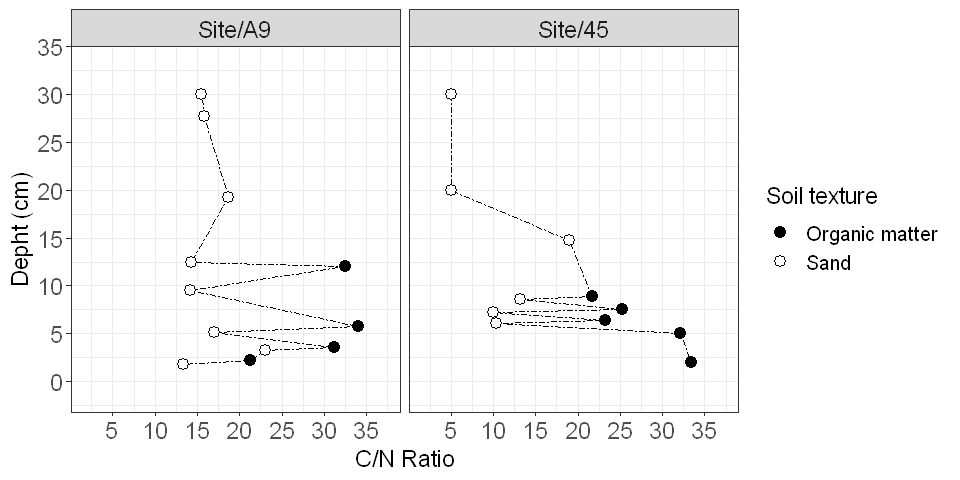

In [58]:
options(repr.plot.width=8, repr.plot.height=4)
pd <- position_dodge(width = 0.2)
New.labs_d <-  c("Site/A9", "Site/45") # Change labels
names(New.labs_d) <- c("Belanger/A9", "Fortier/45")

p <- ggplot(data=Carbon_credit, aes(x= `Depht (cm)`, y= `C/N`)) +
facet_grid(.~Site, labeller = labeller(`Site` = New.labs_d)) +
geom_line(linetype = "twodash") +
labs(y= "C/N Ratio") +
geom_point(aes(shape = `Soil texture`, fill = `Soil texture`), size = 3) +
scale_shape_manual(values=c(21, 21))+
scale_fill_manual(values = c("#000000", "#FFFFFF")) +

scale_y_continuous(breaks = 5*0:1000,
                     expand = expand_scale(add = 5)) +
scale_x_continuous(breaks = 5*0:1000,
                     expand = expand_scale(add = 5)) +
theme(strip.text = element_text(size = 14), axis.text=element_text(size=14),
        axis.title=element_text(size=14) , legend.title= element_text(size=14),
     legend.text = element_text(size=12)) 
p + coord_flip()
ggsave("figures/(C_over_N).png", width = 8, height = 4, dpi = 800)